# Going Deeper 4. 이미지 어디까지 우려볼까?
# **프로젝트: CutMix 또는 Mixup 비교실험 하기**

#### 평가 루브릭

1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?  
CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.


2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?  
Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함


3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?  
기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.

필요한 라이브러리 불러오기

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [ ]:
# 사용가능한 GPU 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# stanford_dogs 데이터셋 다운로드하기
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True,
    data_dir='/content/drive/MyDrive/colab_data'
)

In [ ]:
# 클래스 수 설정
num_classes = ds_info.features['label'].num_classes

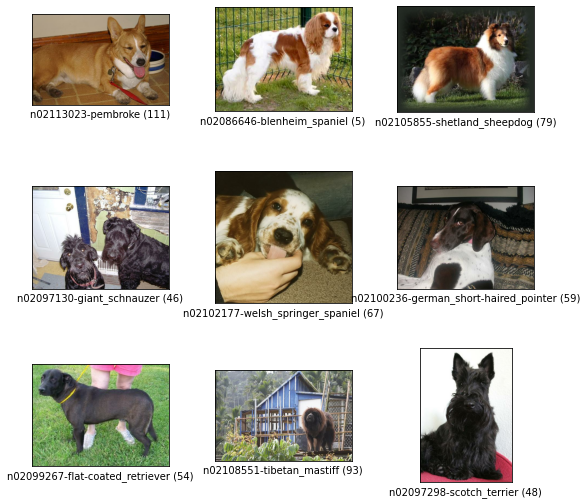

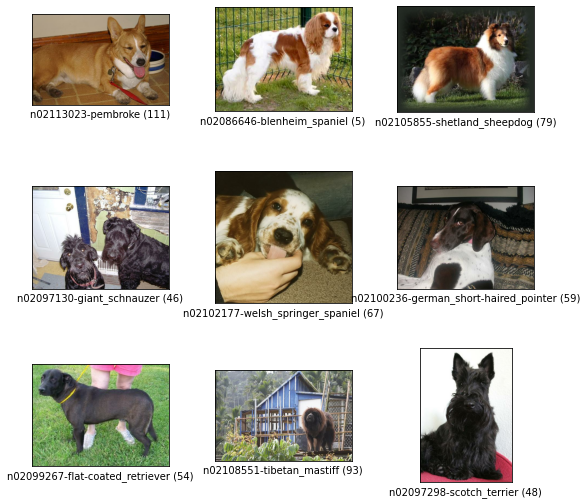

In [ ]:
# 샘플 확인
tfds.show_examples(ds_train, ds_info)

In [ ]:
# 입력받은 이미지를 0~1 사이의 float32로 normalize하고, (224, 224) 사이즈로 resize
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
# 랜덤하게 좌우 대칭을 해주고, 밝기를 조절해준다
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [ ]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

텐서플로우 Random Augmentation API 사용하기

# (1) Cutmix Augmentation

1) 이미지 섞기

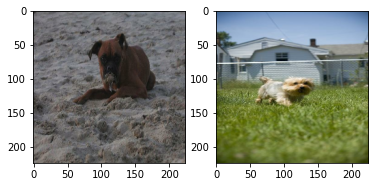

In [ ]:
import matplotlib.pyplot as plt

ds_train_no_aug = apply_normalize_on_dataset(ds_train)

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [ ]:
# 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두 번째 이미지 b가 있을 때, a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    # 붙여넣을 이미지 박스가 붙여넣어질 이미지의 크기를 벗어나지 않게 해줌
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(7, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(127, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


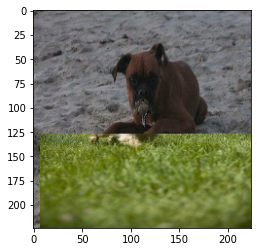

In [ ]:
# 바탕이미지 image_a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

2) 라벨 섞기

섞은 이미지의 면적에 비례하여 라벨을 지정해준다.

In [ ]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.41950336, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

mix_2_images()와 mix_2_label()을 활용하여 배치 단위의 cutmix() 함수를 구현

In [ ]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


# (2) Mixup Augmentation

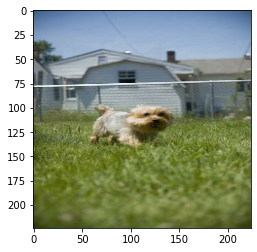

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.9267894 0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.0732106 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

In [ ]:
# function for mixup
# 랜덤하게 비율을 뽑고, 해당 비율에 맞게 픽셀별 값으로 섞는다.
# 비율을 라벨값으로 설정
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

배치 단위의 mixup() 함수를 구현

In [ ]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b, num_classes)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

# 각 기법 적용하기

1. Augmentation을 적용한 데이터셋 만들기

CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 한다.

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label, batch_size=16, img_size=224, num_classes=120):
    new_imgs = []
    new_labels = []
    for i in range(batch_size):
        label_n = label[i]
        if len(label_n.shape)==0:
            label_n = tf.one_hot(label_n, num_classes)
        new_imgs.append(image[i])
        new_labels.append(label_n)

    new_imgs = tf.reshape(tf.stack(new_imgs), (batch_size, img_size, img_size, 3))
    new_labels = tf.reshape(tf.stack(new_labels), (batch_size, num_classes))
    return new_imgs, new_labels

# 데이터셋(ds)을 가공하는 메인함수
# with_aug, with_cutmix, with_mixup을 통해 각 augmentation 수행 여부 확인
# 테스트 데이터에는 augmentation을 안해야하므로 is_test매개변수로 확인
# 또한, cutmix나 mixup을 적용한 경우, 라벨이 onehot 방식이므로 with_onehot으로 테스트 데이터를 생성
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False, with_onehot=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    if is_test and with_onehot:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
# augmentation을 적용한 train 데이터와 하지 않은 train 데이터를 만들고,
# test 데이터는 is_test를 True로 주어 augmentation이 되지 않도록 데이터셋을 만든다.
# test 데이터는 cutmix나 mixup을 적용한 데이터를 위해 onehot 인코딩이 수행된 데이터을 하나 더 만든다.
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_test_no_onehot = apply_normalize_on_dataset(ds_test, is_test=True)
ds_test_onehot = apply_normalize_on_dataset(ds_test, is_test=True, with_onehot=True)

2. 모델 만들기

비교실험 하기

텐서플로우 케라스의 ResNet50 중 imagenet으로 훈련된 모델을 불러온다

In [ ]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # FC 레이어를 포함할지 여부, 클래스가 다르므로 False 설정
        weights='imagenet', # ImageNet으로 학습한 가중치를 불러온다
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# 기본 Augmentation을 적용한 데이터셋으로 학습시킬 ResNet 생성
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# 기본 Augmentation + cutmix 적용한 데이터셋으로 학습시킬 ResNet 생성
aug_cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# 기본 Augmentation + mixup 적용한 데이터셋으로 학습시킬 ResNet 생성
aug_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

3. 모델 훈련하기

(1) 기본 데이터를 통해 학습을 진행

In [ ]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
#EPOCH = 3

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_no_onehot,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 109s 131ms/step - loss: 2.1845 - accuracy: 0.4491 - val_loss: 3.5021 - val_accuracy: 0.1869
Epoch 2/20
750/750 [==============================] - 95s 127ms/step - loss: 0.6703 - accuracy: 0.8193 - val_loss: 1.0621 - val_accuracy: 0.6896
Epoch 3/20
750/750 [==============================] - 94s 126ms/step - loss: 0.1777 - accuracy: 0.9689 - val_loss: 0.9244 - val_accuracy: 0.7267
Epoch 4/20
750/750 [==============================] - 96s 128ms/step - loss: 0.0457 - accuracy: 0.9973 - val_loss: 0.9069 - val_accuracy: 0.7372
Epoch 5/20
750/750 [==============================] - 94s 126ms/step - loss: 0.0199 - accuracy: 0.9999 - val_loss: 0.9170 - val_accuracy: 0.7394
Epoch 6/20
750/750 [==============================] - 95s 126ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.9279 - val_accuracy: 0.7374
Epoch 7/20
750/750 [==============================] - 94s 126ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.9414 - val_a

(2) 기본 Augmentation된 데이터를 통해 학습을 진행

In [ ]:
aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_no_onehot,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 111s 133ms/step - loss: 2.2806 - accuracy: 0.4208 - val_loss: 3.1213 - val_accuracy: 0.2476
Epoch 2/20
750/750 [==============================] - 95s 127ms/step - loss: 0.9802 - accuracy: 0.7177 - val_loss: 1.3525 - val_accuracy: 0.6156
Epoch 3/20
750/750 [==============================] - 95s 127ms/step - loss: 0.5600 - accuracy: 0.8443 - val_loss: 1.2219 - val_accuracy: 0.6488
Epoch 4/20
750/750 [==============================] - 97s 129ms/step - loss: 0.3049 - accuracy: 0.9188 - val_loss: 1.1140 - val_accuracy: 0.6820
Epoch 5/20
750/750 [==============================] - 96s 128ms/step - loss: 0.1655 - accuracy: 0.9642 - val_loss: 0.9948 - val_accuracy: 0.7148
Epoch 6/20
750/750 [==============================] - 96s 128ms/step - loss: 0.0893 - accuracy: 0.9872 - val_loss: 0.9783 - val_accuracy: 0.7312
Epoch 7/20
750/750 [==============================] - 96s 127ms/step - loss: 0.0534 - accuracy: 0.9934 - val_loss: 0.9503 - val_a

(3) 기본 Augmentation + cutmix 적용된 데이터를 통해 학습을 진행

In [ ]:
aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_cutmix = aug_cutmix_resnet50.fit(
    ds_train_aug_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_onehot,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 111s 132ms/step - loss: 3.8586 - accuracy: 0.2017 - val_loss: 3.0712 - val_accuracy: 0.2550
Epoch 2/20
750/750 [==============================] - 98s 131ms/step - loss: 3.0269 - accuracy: 0.4089 - val_loss: 1.4989 - val_accuracy: 0.5770
Epoch 3/20
750/750 [==============================] - 98s 131ms/step - loss: 2.7783 - accuracy: 0.4792 - val_loss: 1.2579 - val_accuracy: 0.6403
Epoch 4/20
750/750 [==============================] - 118s 157ms/step - loss: 2.5860 - accuracy: 0.5449 - val_loss: 1.3448 - val_accuracy: 0.6344
Epoch 5/20
750/750 [==============================] - 118s 158ms/step - loss: 2.4514 - accuracy: 0.5820 - val_loss: 1.1844 - val_accuracy: 0.6732
Epoch 6/20
750/750 [==============================] - 98s 131ms/step - loss: 2.3487 - accuracy: 0.6198 - val_loss: 1.2812 - val_accuracy: 0.6509
Epoch 7/20
750/750 [==============================] - 118s 158ms/step - loss: 2.2216 - accuracy: 0.6553 - val_loss: 1.2345 - va

(4) 기본 Augmentation + mixup 적용된 데이터를 통해 학습을 진행

In [ ]:
aug_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_mixup = aug_mixup_resnet50.fit(
    ds_train_aug_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_onehot,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 112s 133ms/step - loss: 3.8177 - accuracy: 0.2119 - val_loss: 4.1143 - val_accuracy: 0.1220
Epoch 2/20
750/750 [==============================] - 119s 158ms/step - loss: 2.9816 - accuracy: 0.4343 - val_loss: 1.6294 - val_accuracy: 0.5580
Epoch 3/20
750/750 [==============================] - 100s 133ms/step - loss: 2.6912 - accuracy: 0.5412 - val_loss: 1.4605 - val_accuracy: 0.5906
Epoch 4/20
750/750 [==============================] - 101s 134ms/step - loss: 2.5347 - accuracy: 0.5933 - val_loss: 1.3913 - val_accuracy: 0.6090
Epoch 5/20
750/750 [==============================] - 101s 135ms/step - loss: 2.4266 - accuracy: 0.6342 - val_loss: 1.2647 - val_accuracy: 0.6504
Epoch 6/20
750/750 [==============================] - 101s 135ms/step - loss: 2.3129 - accuracy: 0.6768 - val_loss: 1.2665 - val_accuracy: 0.6475
Epoch 7/20
750/750 [==============================] - 101s 135ms/step - loss: 2.2446 - accuracy: 0.7083 - val_loss: 1.2165 -

4. 훈련 과정 시각화하기

In [ ]:
# 히스토리를 저장
'''
np.save('no_aug.npy',history_resnet50_no_aug.history)
np.save('aug.npy',history_resnet50_aug.history)
np.save('aug_cutmix.npy',history_resnet50_aug_cutmix.history)
np.save('aug_mixup.npy',history_resnet50_aug_mixup.history)
'''

In [ ]:
# 히스토리를 불러오기
'''
no_aug=np.load('no_aug.npy',allow_pickle='TRUE').item()
aug=np.load('aug.npy',allow_pickle='TRUE').item()
aug_cutmix=np.load('aug_cutmix.npy',allow_pickle='TRUE').item()
aug_mixup=np.load('aug_mixup.npy',allow_pickle='TRUE').item()
'''

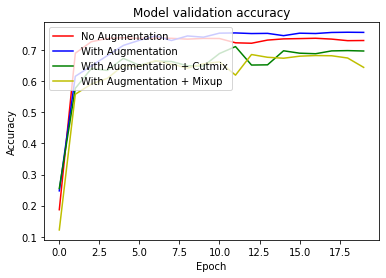

In [ ]:
# 훈련과정 시각화
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Augmentation + Cutmix', 'With Augmentation + Mixup'], loc='upper left')
plt.show()

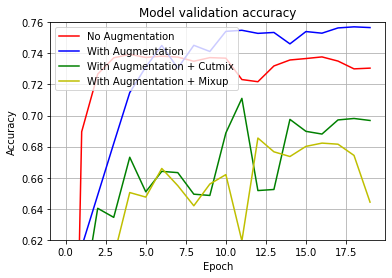

In [ ]:
# 조금 더 확대하여 살펴보기!
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Augmentation + Cutmix', 'With Augmentation + Mixup'], loc='upper left')
plt.grid(True)
#plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
plt.ylim(0.62, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

5. Augmentation에 의한 모델 성능 비교

(1) No Augmentation  
(2) 기본 Augmentation  
(3) 기본 + CutMix 적용  
(4) 기본 + Mixup 적용  

* Validation Accuracy 측면에서 (2) 모델이 약 76% 로 가장 좋은 성능을 보인다.   
그 다음으로는 (1) 모델로 약 74% 에 까까운 결과를 보여준다.
* 당연히 믹스업이나 컷믹스를 적용한 것이 더 좋을 것이라 생각했는데 그렇지 않았다.
* 학습 초반에는 (1) 모델의 정확도가 먼저 높아졌으나 그 후의 개선이 거의 없고,  
(2) 모델의 경우 (1)에 비해 정확도가 늦게 높아졌지만 계속해서 상향되는 경향을 보여주고 있다.
* EPOCH을 더 돌리면 정확도가 높아질 것으로 예측은 되지만 그 폭이 크지 않을것 같다.
* (1)과 (2)는 train loss가 충분히 낮은 값으로 떨어졌으므로 학습이 잘 진행되었다고 볼 수 있지만, (3)과 (4)는 loss 값이 여전히 1을 훌쩍 넘기며 학습이 더딘것을 볼 수 있다.

---

# 데이터셋을 추가해서 사용해보기...?

* Augmentation이라는 것이 데이터를 변환하기는 하지만 기존 데이터에 추가되는 것이 아니기에, augmentation된 데이터로만 학습하는 것은 온전치 않다고 생각했다.  
* 또한, 믹스업이나 컷믹스를 이용한 데이터를 직접 확인했을 때, 기괴한 모습이 많이 보이고 사람 눈으로도 이상하다고 느끼는 데이터가 많았다.  
* 그러므로 원 데이터셋을 그대로 가져가되 그 데이터를 augmentation한 데이터를 추가하여 학습을 해보면 어떨까?
<br/>
<br/>

[학습 모델]  
(1) No Augmentation + No augmentation  
(2) No Augmentation + 기본 Augmentation

In [ ]:
# stanford_dogs 데이터셋 다운로드하기
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True,
    data_dir='/content/drive/MyDrive/colab_data'
)

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False, with_onehot=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )    
    ds = ds.batch(batch_size) 
    o_ds = ds # 기존 데이터를 다른 변수에 지정하여 추가를 준비한다.
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    if is_test and with_onehot:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )        
    if not is_test:
        ds = ds.concatenate(o_ds) # 위에서 지정해준 기존 데이터와 augmentation된 데이터를 합쳐준다.
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
ds_train_no_aug_ = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug_ = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test_no_onehot_ = apply_normalize_on_dataset(ds_test, is_test=True)

In [ ]:
resnet50_ = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # FC 레이어를 포함할지 여부, 클래스가 다르므로 False 설정
        weights='imagenet', # ImageNet으로 학습한 가중치를 불러온다
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50_.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug_ = resnet50_.fit(
    ds_train_no_aug_, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples*2/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_no_onehot,
    verbose=1,
    use_multiprocessing=True,
)

np.save('no_aug_.npy',history_resnet50_no_aug_.history)

Epoch 1/20
1500/1500 [==============================] - 296s 186ms/step - loss: 1.4430 - accuracy: 0.6364 - val_loss: 1.0076 - val_accuracy: 0.7008
Epoch 2/20
1500/1500 [==============================] - 175s 117ms/step - loss: 0.1194 - accuracy: 0.9800 - val_loss: 0.8969 - val_accuracy: 0.7390
Epoch 3/20
1500/1500 [==============================] - 176s 117ms/step - loss: 0.0163 - accuracy: 0.9998 - val_loss: 0.9227 - val_accuracy: 0.7436
Epoch 4/20
1500/1500 [==============================] - 175s 117ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.9448 - val_accuracy: 0.7427
Epoch 5/20
1500/1500 [==============================] - 175s 116ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.9613 - val_accuracy: 0.7425
Epoch 6/20
1500/1500 [==============================] - 174s 116ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.9762 - val_accuracy: 0.7407
Epoch 7/20
1500/1500 [==============================] - 174s 116ms/step - loss: 0.0037 - accuracy: 1.0000 - val_

In [ ]:
aug_resnet50_ = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # FC 레이어를 포함할지 여부, 클래스가 다르므로 False 설정
        weights='imagenet', # ImageNet으로 학습한 가중치를 불러온다
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

aug_resnet50_.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_ = aug_resnet50_.fit(
    ds_train_aug_, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples*2/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_no_onehot,
    verbose=1,
    use_multiprocessing=True,
)

np.save('aug_.npy',history_resnet50_aug_.history)

Epoch 1/20
1500/1500 [==============================] - 181s 114ms/step - loss: 1.6045 - accuracy: 0.5792 - val_loss: 1.2010 - val_accuracy: 0.6507
Epoch 2/20
1500/1500 [==============================] - 171s 114ms/step - loss: 0.3597 - accuracy: 0.9078 - val_loss: 1.0045 - val_accuracy: 0.7106
Epoch 3/20
1500/1500 [==============================] - 172s 115ms/step - loss: 0.1047 - accuracy: 0.9818 - val_loss: 1.0486 - val_accuracy: 0.7085
Epoch 4/20
1500/1500 [==============================] - 173s 115ms/step - loss: 0.0363 - accuracy: 0.9969 - val_loss: 1.0009 - val_accuracy: 0.7274
Epoch 5/20
1500/1500 [==============================] - 173s 115ms/step - loss: 0.0255 - accuracy: 0.9972 - val_loss: 1.1297 - val_accuracy: 0.7156
Epoch 6/20
1500/1500 [==============================] - 172s 115ms/step - loss: 0.0375 - accuracy: 0.9944 - val_loss: 0.9726 - val_accuracy: 0.7434
Epoch 7/20
1500/1500 [==============================] - 172s 115ms/step - loss: 0.0093 - accuracy: 0.9992 - val_

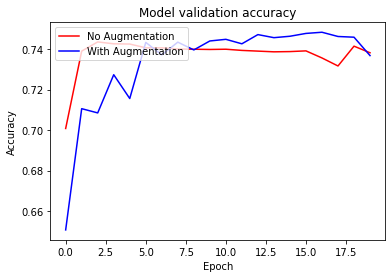

In [ ]:
# 훈련과정 시각화
plt.plot(history_resnet50_no_aug_.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug_.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

* 결과에서 큰 차이를 보지 못했고, 오히려 augmentation을 진행한 모델의 성능이 떨어진 모습을 볼 수 있다.
* 다시 살펴보니 데이터셋을 전처리해주는 함수에서 실수가 있었다.  
augment 함수를 불러오기 전 단계에서 기존 데이터를 다른 변수에 할당해주어야 하는데, 기본 augmentation이 진행된 후에 할당을 해주어 결국 augmentation된 데이터를 두배한 데이터셋이 되었다.
* 기존에 하고자 했던 테스트를 하지 못하였기에 이 결과는 무시하도록 한다.

---

# 결과 및 회고

* 믹스업과 컷믹스 기법을 새롭게 접해보았다.  
이번 테스트에서는 효과를 보지 못하였지만, 해당 기법을 잘 활용하면 다른 문제에서는 효과를 볼 수도 있을 것이다.
* 기본 augmentation의 경우 대체적으로 object의 원형을 유지하고 있으면서도 다양하게 표현이 되기때문에 결과가 가장 좋게 나온것 같다.
* 다양한 방법으로 augmentation을 할 수 있으므로 필요에 따라 방법들을 가감하면서 활용하면, 앞으로의 데이터 부족 문제나 데이터 단순 문제를 해결할 수 있을 것 같다.